In [23]:
import pandas as pd
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import reduce
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold, StratifiedKFold
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from sklearn.metrics import r2_score as R2
from skopt.space import Real, Categorical, Integer
from time import time
from skopt import BayesSearchCV
from functools import partial
import pprint

import warnings
warnings.filterwarnings('ignore')

In [16]:
target = 'NEE'

model = ['rcef_RandomForestRegressor', 'rcef_RidgeCV', 'rcef_XGBRegressor', 'xgboost'] 

extracted_features = model[-1]

In [17]:
# loads all data sets into a dict
def load_datasets(dirs: list, load_path: str) -> dict:
    files = ['soil_c','surf_water','flux_soc','soil_water','n_flux','p_flux','temp', 
         'plant_c','plant_n','plant_p','canopcy_c','plant_stress','photosynthesis','plant_growth']
    
    #files.append('soil_temp', 'canopy_temp') missing 
    datasets = {}
    
    for dr in dirs:
        csv_list = []
        path = 'datasets/' + dr + load_path
        for f in files:
            df = pd.read_csv(os.path.join(path,f + '.csv'))
            df.drop(df.columns[0], axis=1)

            csv_list.append(df)


        data_dict = {}
        for i in range (len(csv_list)):
            data_dict[files[i]] = csv_list[i]

        datasets[dr] = data_dict

    return datasets

dirs = ['warm_temp_maize_soybean_irrigated', 'warm_temp_maize-soybean_dryland', 'cool_temp_maize_soybean']

datasets = load_datasets(dirs, '/csv_outs/with_plant_soil_details/')

In [18]:
def rename_dupes(suffix: str, df: pd.DataFrame, dupes: list) -> pd.DataFrame:
    for col in df.columns:
        if col in dupes:
            df.rename(columns={col: col + suffix}, inplace=True)
    return df

def average_numbered_columns(df):
    numbered_cols = [col for col in df.columns if '_' in col and col.split('_')[-1].isdigit()]

    col_groups = {}
    for col in numbered_cols:
        prefix = '_'.join(col.split('_')[:-1])
        if prefix not in col_groups:
            col_groups[prefix] = []
        col_groups[prefix].append(col)

    # calculate averages and add new columns
    for prefix, cols in col_groups.items():
        avg_col_name = prefix
        avg_col_values = df[cols].mean(axis=1)
        df[avg_col_name] = avg_col_values

    # drop numbered columns
    df = df.drop(columns=numbered_cols)

    return df

# turn all csv's to one dataframe
def to_pd(df: dict, handle_dupes: bool, flatten_num_cols: bool) -> pd.DataFrame:
    x = pd.DataFrame()
    for file_name in df:
        cur = df[file_name]
            
        x = pd.concat([x, df[file_name]], axis = 1)
        
    cheeky_col = 'unnamed.1'
    cheeky_col2 = 'Unnamed: 0'
    if cheeky_col in x.columns:
        x = x.drop([cheeky_col], axis=1)
    elif cheeky_col2 in x.columns:
         x = x.drop([cheeky_col2], axis=1)
    x = x.drop(['DATE'], axis=1)

    if flatten_num_cols:
        x = average_numbered_columns(x)
        
    x = x.loc[:,~x.columns.duplicated()].copy()
    
    one_hot = pd.get_dummies(x['GROWTH_STG'])
    x= x.drop('GROWTH_STG',axis = 1)
    # Join the encoded df
    x = x.join(one_hot)

    x.columns = x.columns.str.translate("".maketrans({"[":"{", "]":"}","<":"^"}))
    
    return x

df_dry = to_pd(datasets['warm_temp_maize-soybean_dryland'], True, True)
df_irr = to_pd(datasets['warm_temp_maize_soybean_irrigated'], True, True)
df_cool = to_pd(datasets['cool_temp_maize_soybean'], True, True)

# NEE = GPP - ER:
#GPP = GROSS PRIMARY PRODUCTION (TOTAL C INTAKE) 
#ER = total C uptake =  ECO_RH + ECO_RA =  autotrophic + heterotrophic respiration 
#NPP = GPP + ECO_RA
df_dry['NEE'] = df_dry['ECO_NPP'] - df_dry['ECO_RH']
df_irr['NEE'] = df_irr['ECO_NPP'] - df_irr['ECO_RH']
df_cool['NEE'] = df_cool['ECO_NPP'] - df_cool['ECO_RH']

df= pd.concat([df_dry, df_irr, df_cool])
y = df[target].copy()
#y = df[target].copy()
#df = df.drop(target, axis=1)

In [21]:
xgbFeatImp = pd.read_csv('feature_analysis/xgboost/FeaturesImportance'  + target  + 'weather_soil_data' + '.csv')
feat_cols = []
for i in range(len(xgbFeatImp.values)):
    feat_cols.append(xgbFeatImp.values[i][0])

y = df[target].copy()
x = df[feat_cols]

#### Normalize using L2 regularization

In [24]:
for entr in x.columns:
    x[entr] = preprocessing.normalize([x[entr]])[0]
y = pd.Series(preprocessing.normalize([y])[0], name='NEE')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
   df, y, test_size=0.33, random_state=41)

In [32]:
def report_perf(optimizer, X, y, title="model", callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    
    if callbacks is not None:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
        
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           + u"\u00B1"+" %.3f") % (time() - start, 
                                   len(optimizer.cv_results_['params']),
                                   best_score,
                                   best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

In [33]:
# Setting the scoring function
scoring = make_scorer(partial(MSE, squared=False), 
                      greater_is_better=False)

# Setting the validation strategy
skf = StratifiedKFold(n_splits=10,
                      shuffle=True, 
                      random_state=0)


In [34]:
# Setting the basic regressor

#if gpu available 
#reg = xg.XGBRegressor(random_state=41, booster='gbtree', objective='reg:squarederror', tree_method='gpu_hist')

reg = xg.XGBRegressor(random_state=41, booster='gbtree', objective='reg:squarederror')


# Setting the search space
search_spaces = {'learning_rate': Real(0.01, 1.0, 'uniform'),
                 'max_depth': Integer(2, 12),
                 'subsample': Real(0.1, 1.0, 'uniform'),
                 'colsample_bytree': Real(0.1, 1.0, 'uniform'), # subsample ratio of columns by tree
                 'reg_lambda': Real(1e-9, 100., 'uniform'), # L2 regularization
                 'reg_alpha': Real(1e-9, 100., 'uniform'), # L1 regularization
                 'n_estimators': Integer(50, 5000)
   }

### Bayesian optimiser

In [35]:
#fix deprecated stuff*
np.int = np.int64

In [ ]:
# Wrapping everything up into the Bayesian optimizer
opt = BayesSearchCV(estimator=reg,                                    
                    search_spaces=search_spaces,                      
                    scoring=scoring,                                  
                    cv=7,                                           
                    n_iter=120,                                       # max number of trials
                    n_points=1,                                       # number of hyperparameter sets evaluated at the same time
                    n_jobs=1,                                         # number of jobs
                    iid=False,                                        # if not iid it optimizes on the cv score
                    return_train_score=False,                         
                    refit=False,                                      
                    optimizer_kwargs={'base_estimator': 'GP'},        # optmizer parameters: we use Gaussian Process (GP)
                    random_state=41)                                   # random state for replicability

# Running the optimizer
overdone_control = DeltaYStopper(delta=0.0001)                    # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60*60*4)          # We impose a time limit (7 hours)

best_params = report_perf(opt, x, y, 'XGBoost_regression', 
                          callbacks=[overdone_control, time_limit_control])

In [38]:
# Transferring the best parameters to our basic regressor
reg =xg.XGBRegressor(random_state=0, booster='gbtree', objective='reg:squarederror', **best_params)

In [39]:
reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [40]:
# Predict the model
pred = reg.predict(X_test)

RMSE :  89.783181


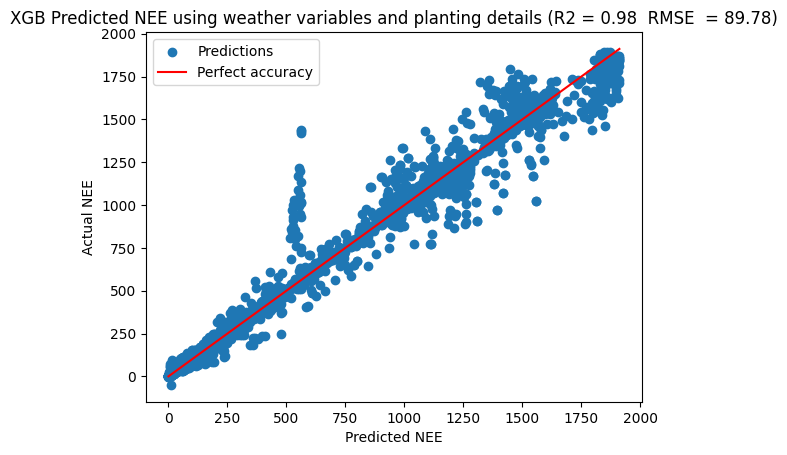

In [41]:
# Calculate R2 score
r2 = R2(y_test, pred)

rmse = np.sqrt(MSE(y_test, pred))
print("RMSE : % f" %(rmse))

# Create scatter plot
plt.scatter(y_test, pred)

# Plot a red line for perfect accuracy
x = np.linspace(min(y_test), max(y_test), 100)
plt.plot(x, x, color='r')

# Add title and legend
plt.title("XGB Predicted " + target +  " using weather variables and planting details (R2 = %0.2f  RMSE  = %0.2f)" %  (r2, rmse))
plt.legend(['Predictions', 'Perfect accuracy'], loc='upper left')
plt.xlabel("Predicted NEE")
plt.ylabel("Actual NEE")

plt.savefig("results/HyperParam XGB" + target + "with_planting_details.png" )
# Show plot
plt.show()

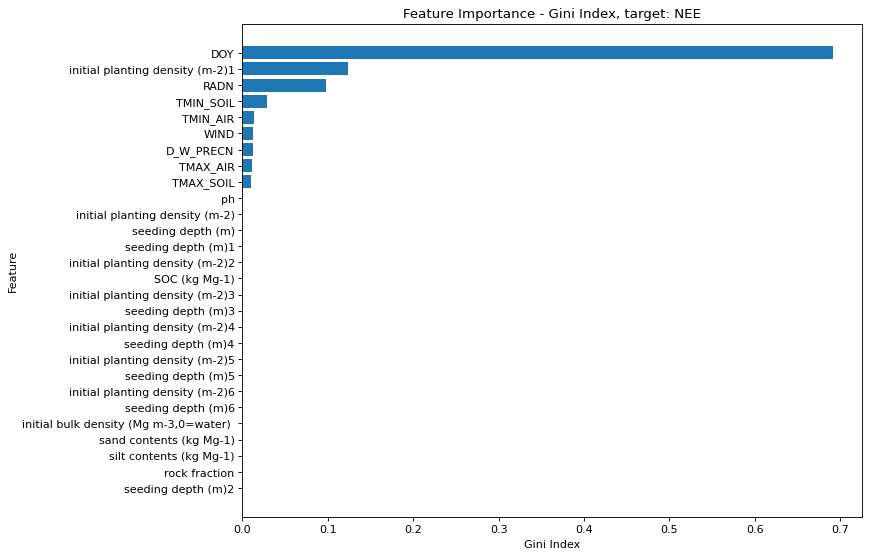

In [42]:
importances = pd.DataFrame({'GINI': reg.feature_importances_}, index=df.columns).sort_values(by='GINI', ascending=True)

# Create a horizontal bar chart
plt.figure(figsize=(10, 8), dpi=80)
plt.barh(importances.index, importances['GINI'])

# Add title and axis labels
plt.title('Feature Importance - Gini Index, target: NEE')
plt.xlabel('Gini Index')
plt.ylabel('Feature')

plt.savefig('results/HyperParamFeatureImportanceGiniIndex' + target + "with_planting_details.png")
# Show the plot
plt.show()

In [43]:
import pickle
file_name = "models/xgb_reg.pkl"

# save
pickle.dump(reg, open(file_name, "wb"))
reg.save_model('models/xgb_reg.json')

In [5]:
reg = xg.XGBRegressor(random_state=41, booster='gbtree', objective='reg:squarederror')

reg.load

In [2]:
model_xgb_2 = xg.XGBRegressor()
model_xgb_2.load_model("models/xgb_reg.json")

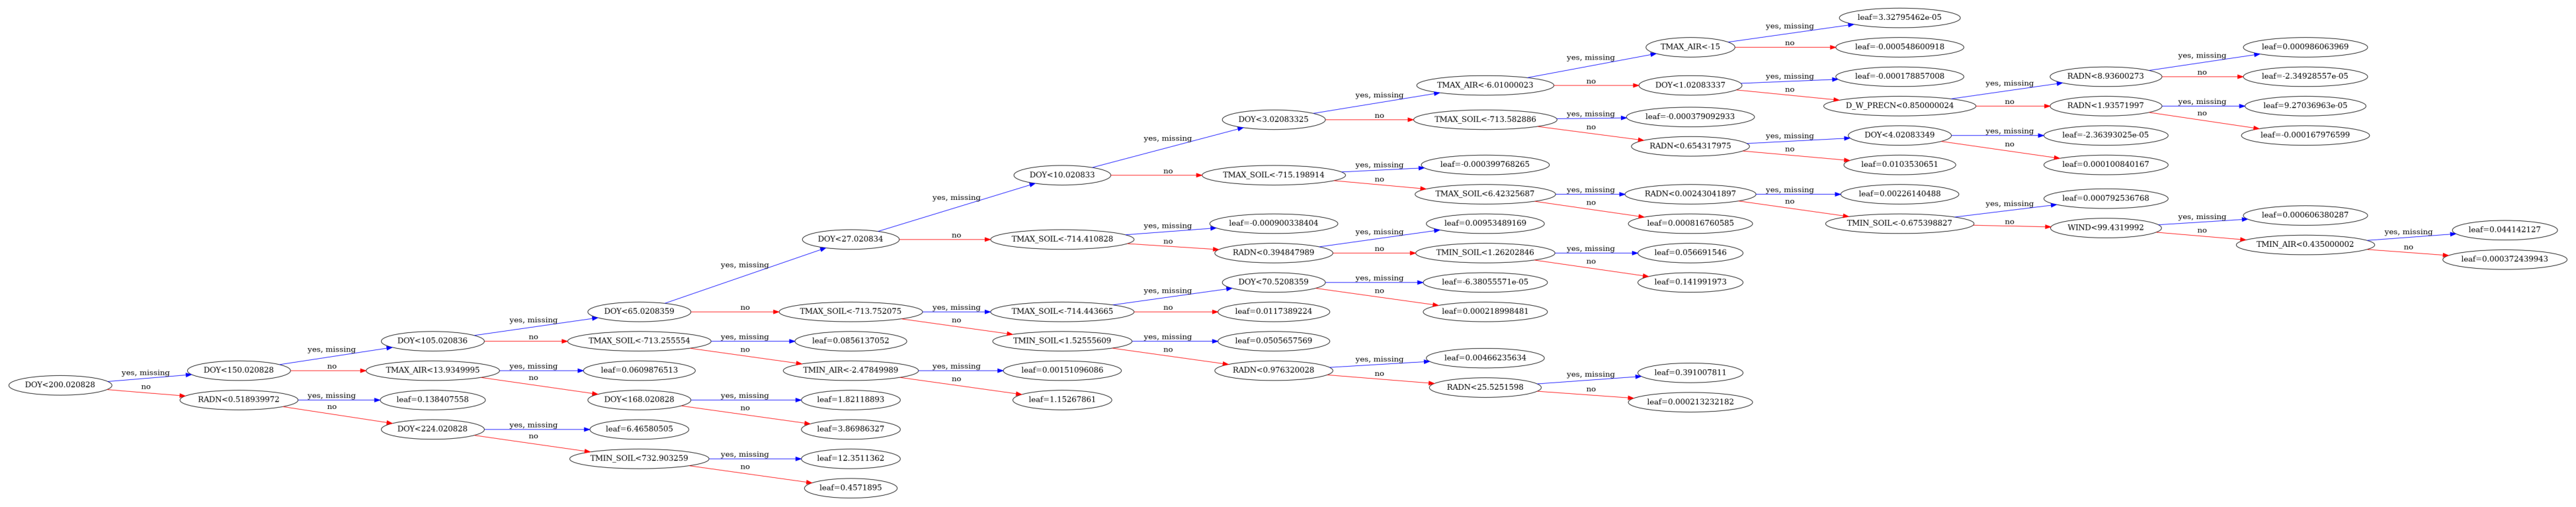

In [9]:
from xgboost import plot_tree

fig, ax = plt.subplots(figsize=(50, 70))
plot_tree(model_xgb_2, num_trees=0, rankdir='LR', ax = ax)
plt.show()

In [10]:
model_xgb_2.fit()

TypeError: fit() missing 2 required positional arguments: 'X' and 'y'